In [1]:
# plot composites for individual months
#
# below, the following can be plotted: 
#
# Fig 7 in paper (Nov, totChl)
# Fig S4 & S5 in paper (ONDJ, totChl)
# Fig 8 in paper (Nov, SLP, wind speed, incoming PAR MLD)
# Fig 9 in paper (Nov, surface NPP, growth rates of diatoms & SP, integrated NPP)
# Fig S7 in paper (Nov, diatom & SP Fe and light limitation)
#

In [2]:
import os
from tqdm import tqdm
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset, MFDataset
import numba as nb
import time as timing
from numba import njit 
from math import sin, cos, sqrt, atan2, radians
from geopy.distance import distance
import seawater as sw
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

In [3]:
#---
# CHOOSE YEARS to plot
#---

years = np.arange(1997,2018+1,1) 

#---
# SAVEPATH
#---

#---
# where to save plots?
#---
savepath_aux     = '/global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/composites_1997_2018_subtract_clim_first/'+\
                    'composites_FIXED_DUPLICATES/'
# check existence of paths
if not os.path.exists(savepath_aux):
    print ('Created '+savepath_aux)
    os.makedirs(savepath_aux)
    
dpicnt = 150
save_plots    = True
display_plots = True


In [4]:
#---
# FUNCTION 
#---

def get_distance_to_storm_center(lat2,lon2,aux_lat,aux_lon):
                
    # create list of locations within 1000km of the storm
    points_data = []
    for pp in range(0,lat2.shape[0]):
        aux = (lat2[pp],lon2[pp])
        points_data.append(aux)
        del aux

    #print(len(points_data))
    # for each of these points get the distance to the storm center in km -> get distance in x-dir and y-dir
    points_distance_x = np.zeros(len(points_data)) # distance in longitudinal direction, i.e., use latitude of storm (aux_lat)
    points_distance_y = np.zeros(len(points_data)) # distance in latitudinal direction, i.e., use longitude of storm (aux_lon)
    for pp in range(0,len(points_data)): 
        # distance in longitudinal direction
        aux_point = (aux_lat,points_data[pp][1])
        points_distance_x[pp] = distance(point_storm, aux_point).km
       # print(aux_point,point_storm,points_distance_x[pp])
        # check sign: if lon grid cell is smaller (=further west) than lon of storm, define distance to be negative
        if points_data[pp][1]<aux_lon:
            points_distance_x[pp] = -1*points_distance_x[pp]
        elif (aux_lon<0) & (points_data[pp][1]>0): # lon_storm is east of dateline, but grid cell is west of dateline (grid cell is also further west in this case!)
            if (points_data[pp][1]-360)<aux_lon:
                points_distance_x[pp] = -1*points_distance_x[pp]
        del aux_point
        # distance in latitudinal direction
        aux_point = (points_data[pp][0],aux_lon)
        points_distance_y[pp] = distance(point_storm, aux_point).km
        # check sign: if lat grid cell is smaller (=further south) than lat of storm, define distance to be negative
        if points_data[pp][0]<aux_lat:
            points_distance_y[pp] = -1*points_distance_y[pp]
        del aux_point  
    return points_distance_x,points_distance_y,points_data
                    
    
def bin_points_as_distance_to_storm_center(counter,points_distance_x,points_distance_y,x_bins,y_bins,aux_data_anom,data_storm_mean,data_storm_std,data_storm_count):
    # data_storm_mean,data_storm_std,data_storm_count: initialized arrays, will be filled in this function and then returned
    
    # bin the points (account for where each point is relative to storm center)
    ind_x = np.digitize(points_distance_x,x_bins,right=False) # minimum is 1 (not zero!!)
    ind_y = np.digitize(points_distance_y,y_bins,right=False)
 #   print(np.min(ind_x),np.max(ind_x))
 #   print(np.min(ind_y),np.max(ind_y))
    # returned index satisfies: bins[i-1] <= x < bins[i]

   # print(aux_data_anom.shape)
    for xx in range(1,len(x_bins)+1): # start at 1 here -> see note above for ind_x
        for yy in range(1,len(x_bins)+1):
            index = np.where((ind_y==yy) & (ind_x==xx))[0]
            if len(index)>0:
                #if counter==6: 
                #    print(xx,yy,index.shape,aux_data_anom.shape)
                #if (counter==40) & (xx==11) & (yy==20):
                #    print(xx,yy,len(points_distance_x))
                #    print(index)
                #    print(index.shape,aux_data_anom.shape)
                # anomaly 2
                data_storm_mean[xx-1,yy-1]  = np.nanmean(aux_data_anom[index])
                data_storm_std[xx-1,yy-1]   = np.nanstd(aux_data_anom[index])
                data_storm_count[xx-1,yy-1] = index.shape[0]
            del index
    return data_storm_mean,data_storm_std,data_storm_count
    
def get_median_ratio(data_storm_aux,data_dev_aux,month_storm_aux,ratio_median,ratio_median_monthly):
    
    # get the median ratio for each year
    counter = 0
    for ss in range(0,data_storm_aux.shape[0]):
        aux_field = 100*(np.nanmean(data_storm_aux[ss,:,:])/np.nanmean(data_dev_aux[ss,:,:]))
        if not np.isnan(aux_field):
            ratio_median[yy] = ratio_median[yy] + aux_field
            counter = counter+1
    ratio_median[yy] = np.divide(ratio_median[yy],counter)
    
    # get the median ratio for each year, EACH MONTH
    for mm in range(0,12):
        ind_mm = np.where(month_storm_aux==mm+1)[0]
        counter = 0
        for ss in ind_mm: 
            aux_field = 100*(np.nanmean(data_storm_aux[ss,:,:])/np.nanmean(data_dev_aux[ss,:,:]))
            if not np.isnan(aux_field):
                ratio_median_monthly[yy,mm] = ratio_median_monthly[yy,mm] + aux_field
                counter = counter+1
        ratio_median_monthly[yy,mm] = np.divide(ratio_median_monthly[yy,mm],counter)
        
    return ratio_median,ratio_median_monthly

def grow_arrays(yy,data_storm_aux,month_storm_aux,lat_storm_aux,lon_storm_aux,slp_avg_storm_aux,slp_min_storm_aux,\
                        data_storm,month_storm,lat_storm,lon_storm,slp_avg_storm,slp_min_storm): 
    if yy==0:
        data_storm  = data_storm_aux
        month_storm = month_storm_aux
        lat_storm   = lat_storm_aux
        lon_storm   = lon_storm_aux
        slp_min_storm   = slp_min_storm_aux
        slp_avg_storm   = slp_avg_storm_aux
    else:
        data_storm  = np.concatenate((data_storm,data_storm_aux))
        month_storm = np.concatenate((month_storm,month_storm_aux))
        lat_storm   = np.concatenate((lat_storm,lat_storm_aux))
        lon_storm   = np.concatenate((lon_storm,lon_storm_aux))
        slp_min_storm   = np.concatenate((slp_min_storm,slp_min_storm_aux))
        slp_avg_storm   = np.concatenate((slp_avg_storm,slp_avg_storm_aux))
                
    return data_storm,month_storm,lat_storm,lon_storm,slp_avg_storm,slp_min_storm

def load_data(path1a,file1,vari1a): 
    # storm-induced anomaly
    ff  = xr.open_dataset(path1a+file1)
    data_storm_aux  = ff[vari1a].values 
    month_storm_aux = ff['month_storm'].values  # at min. SLP
    lat_storm_aux   = ff['lat_storm'].values  # at min. SLP
    lon_storm_aux   = ff['lon_storm'].values  # at min. SLP
    slp_avg_storm_aux   = ff['avg_min_slp_storm'].values  # avg of all min SLP over all time steps of the storm's existence 
    slp_min_storm_aux   = ff['min_min_slp_storm'].values  # min. SLP over all time steps of the storm's existence 
    ff.close()
    data_storm_aux[data_storm_aux==0] = np.nan
    
    return data_storm_aux,month_storm_aux,lat_storm_aux,lon_storm_aux,slp_avg_storm_aux,slp_min_storm_aux



-------
Plot  MLD 
-------

Created /global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/composites_1997_2018_subtract_clim_first/composites_FIXED_DUPLICATES/MLD_TEST_gap_filling_emulator/monthly/
Created /global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/composites_1997_2018_subtract_clim_first/composites_FIXED_DUPLICATES/MLD_TEST_gap_filling_emulator/monthly/eps/


/tmp/ipykernel_201447/3612435183.py:213: RuntimeWarning: Mean of empty slice
  data_aux_mean = np.nanmean(np.nanmean(data_aux,axis=2),axis=1)
/tmp/ipykernel_201447/3612435183.py:345: RuntimeWarning: Mean of empty slice
  data_aux_mean = np.nanmean(np.nanmean(data_aux,axis=2),axis=1)
/tmp/ipykernel_201447/3612435183.py:473: RuntimeWarning: invalid value encountered in true_divide
  data_count_all_rel_pos[mm,:,:] = 100*data_count_all/np.nansum(data_count_max2[ind_storm2])
/tmp/ipykernel_201447/3612435183.py:468: RuntimeWarning: invalid value encountered in true_divide
  data_count_all_rel_neg[mm,:,:] = 100*data_count_all/np.nansum(data_count_max1[ind_storm1])


data_storm.shape (9615, 21, 21)
data_storm_chl.shape (9615, 21, 21)

Only consider storms with data in LOW RES full in analysis...
BEFORE kicking out NaNs: data_storm.shape (9615, 21, 21)
AFTER kicking out NaNs: data_storm.shape (9554, 21, 21)
AFTER kicking out NaNs: data_storm_abs.shape (9554, 21, 21)
AFTER kicking out NaNs: data_storm_chl.shape (9554, 21, 21)
identify the strongest storms based on LOW RES full field...
thrsh1,thrsh2 -0.030338433757424354 0.02789403870701792

LOW RES
(956,) (956,)
(956, 21, 21) (956, 21, 21)
LOW RES full field...


  0%|          | 0/12 [00:00<?, ?it/s]

Nov ...
num_storms1 267
MIN of negative anomalies -5.016615
MAX of negative anomalies 22.364336
2nd largest MAX of negative anomalies 12.485457
MIN of ABSOLUTE 51.352127
MAX of ABSOLUTE 120.589005


/tmp/ipykernel_201447/3612435183.py:566: RuntimeWarning: Mean of empty slice
  aux1 = np.nanmean(np.nanmean(data_aux_mean_lr1_aux,axis=2),axis=1)
/tmp/ipykernel_201447/3612435183.py:567: RuntimeWarning: Mean of empty slice
  aux2 = np.nanmean(np.nanmean(data_aux_mean_lr2_aux,axis=2),axis=1)
/tmp/ipykernel_201447/3612435183.py:575: RuntimeWarning: Mean of empty slice
  avg_anom_strongest_neg[mm] = np.nanmean(data_aux_mean_lr1_aux) # strongest negative anomaly
/tmp/ipykernel_201447/3612435183.py:576: RuntimeWarning: Mean of empty slice
  avg_anom_strongest_pos[mm] = np.nanmean(data_aux_mean_lr2_aux) # strongest positive anomaly
/tmp/ipykernel_201447/3612435183.py:626: RuntimeWarning: Mean of empty slice
  data_plot0 = np.nanmean(data_aux_mean_lr_all_aux,axis=0)
/tmp/ipykernel_201447/3612435183.py:627: RuntimeWarning: Mean of empty slice
  data_plot1 = np.nanmean(data_aux_mean_lr1_aux,axis=0)
/tmp/ipykernel_201447/3612435183.py:628: RuntimeWarning: Mean of empty slice
  data_plot2 = np.na

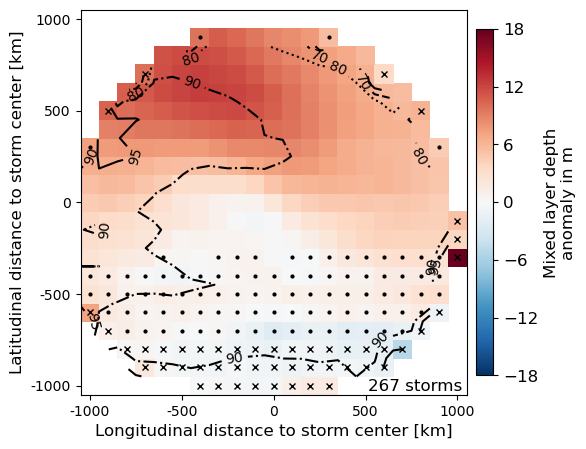

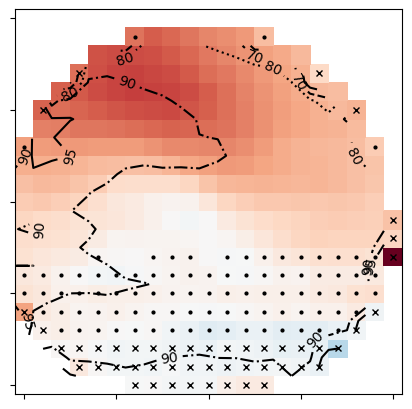

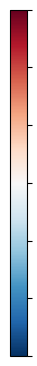

num_storms2 218
MIN of positive anomalies -17.006351
2nd largest MIN of negative anomalies -16.935177
MAX of positive anomalies 8.052816
2nd largest MAX of negative anomalies 7.1814675
MIN of ABSOLUTE 40.896317
MAX of ABSOLUTE 105.645355


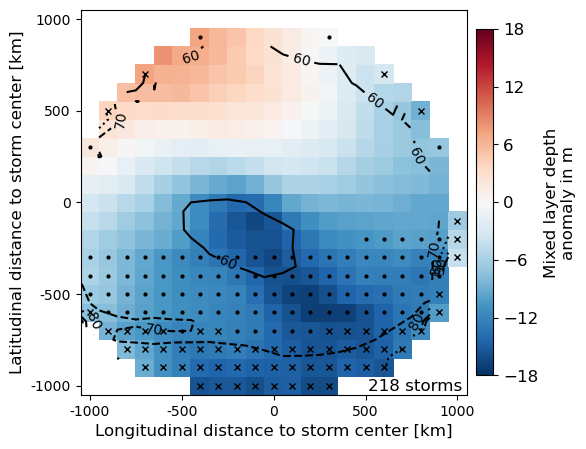

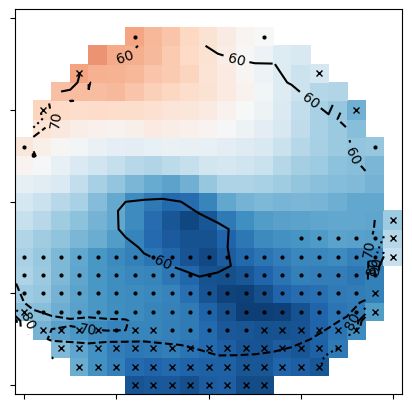

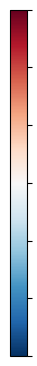

100%|██████████| 12/12 [00:03<00:00,  3.26it/s]

done  


In [21]:
#---
# LOAD COMPOSITES for totChl (low res/full, low res/emulator, high res)
#---

year_list = np.arange(1997,2018+1,1)

save_plots    = True
display_plots = True    
display_plots_monthly = True
plot_monthly= True

months_to_plot = [10] # choose which months to plot (main text only has November, supplement has Oct,Nov,Dec,Jan)

# options for emulator & hr
plot_emulator_hr = True # for some time_strings, these are not yet available!
full_field_clim_for_em = False 
# if True, use full field clim for emulator (as done in main part of paper); set to False for suppl. plots

#-----
# DEFINE VARIABLE LIST: choose one of below (note: time_string_list and vari_list must be identical in length)

# FIG 7 (and Fig. S4 & S5)
vari_list = ['totChl'] # if totChl is selected, emulator and hr are also plotted
time_string_list = ['']

# FIG 8 
#vari_list = ['slp','wind_speed','PAR_incoming','MLD'] # Fig. 8
#time_string_list = ['','','','']

# FIG 9
#vari_list = ['photoC_total_surf','mu_diat','mu_sp','photoC_zint'] # Fig. 9
#time_string_list = ['','','','']

# FIG S7
#vari_list = ['diat_Fe_lim_surf','diat_light_lim_surf','sp_Fe_lim_surf','sp_light_lim_surf'] 
#time_string_list = ['','','','']

#------
    
perc1 = 10 #25
perc2 = 90 #75

for vv in range(0,len(vari_list)):
    vari = vari_list[vv]
    time_string = time_string_list[vv]
    print()
    print('-------')
    print('Plot ',vari,time_string)
    print('-------')
    print()

    # where are data
    path1 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_anomalies/'
    path2 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_emulator_anomalies/TEST/' # correct composite files
    path3 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_hr_anomalies/'

    # if vari is not totChl, provide path to totChl (LOW RES, full & emulator) here --> files need to be loaded so that strongest storms can be identified correctly
    path_chl    = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/totChl_anomalies/'
    path_chl_em = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/totChl_emulator_anomalies/'

    if time_string=='':
        savepath = savepath_aux+vari+'_TEST_gap_filling_emulator/'
    else:
        savepath = savepath_aux+vari+'/'+time_string+'_v2/'
    # check existence of paths
    if not os.path.exists(savepath):
        print ('Created '+savepath)
        os.makedirs(savepath)
    savepath_eps = savepath+'eps/'
    # check existence of paths
    if not os.path.exists(savepath_eps):
        print ('Created '+savepath_eps)
        os.makedirs(savepath_eps)
        
    savepath2 = savepath+'monthly/'
    # check existence of paths
    if not os.path.exists(savepath2):
        print ('Created '+savepath2)
        os.makedirs(savepath2)
    savepath2_eps = savepath2+'eps/'
    # check existence of paths
    if not os.path.exists(savepath2_eps):
        print ('Created '+savepath2_eps)
        os.makedirs(savepath2_eps)

    #----
    # LOW RES, FULL FIELD
    #----

    # storm-induced anomaly
    file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_'+vari+'_'+\
                str(year_list[0])+'_'+str(year_list[-1])+time_string+'_subtract_clim_first.nc'
    file1b = 'Composite_abs_field_within_1000km_of_storm_center_at_noon_'+vari+'_'+\
                str(year_list[0])+'_'+str(year_list[-1])+time_string+'_subtract_clim_first.nc'

    # load data
    data_storm,month_storm,lat_storm,\
                lon_storm,slp_avg_storm,slp_min_storm = load_data(path1,file1,vari+'_storm_anomaly4_mean')

    #---
    # ABS
    #---
    # load data
    data_storm_abs,month_storm_abs,lat_storm_abs,\
                lon_storm_abs,slp_avg_storm_abs,slp_min_storm_abs = load_data(path1,file1b,vari+'_storm_mean')

        
    # if I chose a different variable above, load totChl of LOW RES anyway (full + emulator)
    #   (for determining storms with strongest impact)
    #
    # NOTE: always load data on day of storm passing here! This is the basis for determining the strongest storms.
    #
    if (not vari=='totChl') | (not time_string==''): 
        #----
        # LOW RES, FULL FIELD, anomalies only (only needed to determine strongest storms)
        #----

        # storm-induced anomaly
        file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_'+\
                    str(year_list[0])+'_'+str(year_list[-1])+''+'_subtract_clim_first.nc'
        file1b = 'Composite_abs_field_within_1000km_of_storm_center_at_noon_'+vari+'_'+\
                    str(year_list[0])+'_'+str(year_list[-1])+''+'_subtract_clim_first.nc'

        # load data
        data_storm_chl,month_storm_chl,lat_storm_chl,\
                     lon_storm_chl,slp_avg_storm_chl,slp_min_storm_chl = load_data(path_chl,file1,'totChl_storm_anomaly4_mean')
        
    if (vari=='totChl') & plot_emulator_hr:
        #----
        # LOW RES, EMULATOR
        #----

        if full_field_clim_for_em:
            em_string  = ''
        else: # use emulator-based climatology (gap-filled)   
            em_string = '_gap_filled_clim'
        print('em_string',em_string)
        
        # storm-induced anomaly
        file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_emulator_'+\
                    str(year_list[0])+'_'+str(year_list[-1])+time_string+'_subtract_clim_first'+em_string+'.nc'
        file1b = 'Composite_abs_field_within_1000km_of_storm_center_at_noon_totChl_emulator_'+\
                str(year_list[0])+'_'+str(year_list[-1])+time_string+'_subtract_clim_first'+em_string+'.nc'

        # load data
        data_storm_em,month_storm_em,lat_storm_em,lon_storm_em,\
                    slp_avg_storm_em,slp_min_storm_em = load_data(path2,file1,vari+'_emulator_storm_anomaly4_mean')

        #----
        # HIGH RES, FULL FIELD
        #----

        # storm-induced anomaly
        file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_hr_'+\
                    str(year_list[0])+'_'+str(year_list[-1])+time_string+'_subtract_clim_first.nc'
        file1b = 'Composite_abs_field_within_1000km_of_storm_center_at_noon_totChl_hr_'+\
                    str(year_list[0])+'_'+str(year_list[-1])+time_string+'_subtract_clim_first.nc'

        # load data
        data_storm_hr,month_storm_hr,lat_storm_hr,lon_storm_hr,\
                slp_avg_storm_hr,slp_min_storm_hr = load_data(path3,file1,vari+'_storm_anomaly4_mean')

        #---
        # ABS
        #---
        # load data
        data_storm_hr_abs,month_storm_hr_abs,lat_storm_hr_abs,\
                    lon_storm_hr_abs,slp_avg_storm_hr_abs,slp_min_storm_hr_abs = load_data(path3,file1b,vari+'_storm_mean')

            

    print('data_storm.shape',data_storm.shape)
    if (vari=='totChl') & plot_emulator_hr:
        print('data_storm_em.shape',data_storm_em.shape)
        print('data_storm_hr.shape',data_storm_hr.shape)
    if (not vari=='totChl') | (not time_string==''): 
        print('data_storm_chl.shape',data_storm_chl.shape)

    #---
    # only consider storms that have data in LOW RES full (correct arrays here)
    #---
    print()
    print('Only consider storms with data in LOW RES full in analysis...')

    # what is the array called that contains totChl (LOW RES full)?
    if time_string=='':
        if vari=='totChl':
            data_aux    = np.copy(data_storm)
        else:
            data_aux    = np.copy(data_storm_chl)
    else: # if BEFORE/AFTER is chosen, always use "chl on day of storm passing" here (--> basis for selction of strong storms)
        data_aux    = np.copy(data_storm_chl)

    # find storms of interest based on chl anomalies
    data_aux_mean = np.nanmean(np.nanmean(data_aux,axis=2),axis=1)
    ind_no_NaN = np.where(~np.isnan(data_aux_mean))[0]

    print('BEFORE kicking out NaNs: data_storm.shape',data_storm.shape)
    if time_string=='_plus_4_days':
        data_storm  = data_storm[ind_no_NaN[:-1],:,:]
        month_storm = month_storm[ind_no_NaN[:-1]]
        lat_storm   = lat_storm[ind_no_NaN[:-1]]
        lon_storm   = lon_storm[ind_no_NaN[:-1]]
        slp_avg_storm = slp_avg_storm[ind_no_NaN[:-1]]
        slp_min_storm = slp_min_storm[ind_no_NaN[:-1]]
        data_storm_abs = data_storm_abs[ind_no_NaN[:-1],:,:]
    else:
        data_storm  = data_storm[ind_no_NaN,:,:]
        month_storm = month_storm[ind_no_NaN]
        lat_storm   = lat_storm[ind_no_NaN]
        lon_storm   = lon_storm[ind_no_NaN]
        slp_avg_storm = slp_avg_storm[ind_no_NaN]
        slp_min_storm = slp_min_storm[ind_no_NaN]
        data_storm_abs = data_storm_abs[ind_no_NaN,:,:]
    print('AFTER kicking out NaNs: data_storm.shape',data_storm.shape)
    print('AFTER kicking out NaNs: data_storm_abs.shape',data_storm_abs.shape)
    if (not vari=='totChl') | (not time_string==''): 
        data_storm_chl  = data_storm_chl[ind_no_NaN,:,:]
        print('AFTER kicking out NaNs: data_storm_chl.shape',data_storm_chl.shape)

    # emulator & HR: only consider storms that have data in LOW RES full
    if (vari=='totChl') & plot_emulator_hr:
        if time_string=='_plus_4_days':
            data_storm_em     = data_storm_em[ind_no_NaN[:-1],:,:]
            data_storm_hr     = data_storm_hr[ind_no_NaN[:-1],:,:]
            data_storm_hr_abs = data_storm_hr_abs[ind_no_NaN[:-1],:,:]
        else:
            data_storm_em     = data_storm_em[ind_no_NaN,:,:]
            data_storm_hr     = data_storm_hr[ind_no_NaN,:,:]
            data_storm_hr_abs = data_storm_hr_abs[ind_no_NaN,:,:]
        print('AFTER kicking out NaNs: data_storm_em.shape',data_storm_em.shape)
        print('AFTER kicking out NaNs: data_storm_hr.shape',data_storm_hr.shape)
        print('AFTER kicking out NaNs: data_storm_hr_abs.shape',data_storm_hr_abs.shape)
        
    #---
    # settings for plotting
    #---

    def plot_composite(data_plot,data_plot_abs,data_stippling,thrsh_list,v1,v2,contours_abs,\
                       cbar_label,num_storms,label_string,time_string,save_plots,display_plots,savepath,filename):

        cmap1  = plt.cm.RdBu_r
        fs     = 10
        dpicnt = 150
        lw = 1
        if contours_abs[0]<1:
            if contours_abs[0]<0.1:
                format_labels = "%1.3f"
            else:
                format_labels = "%1.2f"
        else:
            format_labels = "%d"

        res    = 100
        x_bins = np.arange(-1000,1000+res,res)
        y_bins = np.arange(-1000,1000+res,res)
        xticks = np.arange(0,len(x_bins))
        xticks = [(x+0.5) for x in xticks]

        plot_abs = False
        if plot_abs:
            fig = plt.figure(figsize=(6,5))
            plt.pcolor(data_plot_abs.transpose(),cmap=plt.cm.RdYlBu_r,vmin=0,vmax=0.4)
            plt.colorbar()
            plt.show()

        add_stippling = True

        fig = plt.figure(figsize=(6,5))
        m1=plt.pcolor(data_plot.transpose(),cmap=cmap1,vmin=v1,vmax=v2)
        cbar=plt.colorbar(m1,orientation='vertical',shrink=0.9,pad=0.02)#,ticks=cticks)
        cbar.set_label(cbar_label,fontsize=fs)
        cbar.ax.tick_params(labelsize=fs)
        cbar.ax.set_yticklabels(cticks)
        plt.xticks(xticks[0::5],x_bins[0::5])
        plt.yticks(xticks[0::5],y_bins[0::5])
        plt.ylabel('Latitudinal distance to storm center [km]',fontsize=fs)
        plt.xlabel('Longitudinal distance to storm center [km]',fontsize=fs)
        plt.annotate(label_string,xy=(0.005,1.015),xycoords='axes fraction',fontsize=fs,ha='left') 
        plt.annotate(str(num_storms)+' storms',xy=(0.99,0.01),xycoords='axes fraction',fontsize=fs,ha='right') 
        CS=plt.contour(data_plot_abs.transpose(),levels=contours_abs,colors=['k','k','k','k','k','k','k'],\
                    linewidths=[lw,lw,lw,lw,lw,lw,lw],linestyles=['-','--',':','-.','-','--',':'])
        try:
            CS.clabel(contours_abs, inline=1, fmt=format_labels, fontsize=10)
        except:
            pass

        if add_stippling:
            #data_stippling = np.copy(data_count_all_rel)[mm,:,:]
            # add stippling for locations with value below XX%
            threshold1 = thrsh_list[0] #25
            for xx in range(0,len(xticks)):
                for yy in range(0,len(xticks)):
                    if data_stippling.transpose()[xx,yy]<=threshold1:
                        plt.plot(yy+0.5,xx+0.5,'ko',markerfacecolor='none',markersize=4,linewidth=1)
            threshold2 = thrsh_list[1] #40
            for xx in range(0,len(xticks)):
                for yy in range(0,len(xticks)):
                    if (data_stippling.transpose()[xx,yy]<=threshold2) & (data_stippling.transpose()[xx,yy]>threshold1):
                        plt.plot(yy+0.5,xx+0.5,'k.',markersize=1)
        if time_string in ['_plus_1_days','_plus_2_days','_plus_3_days']:
            plt.annotate('+'+time_string[6]+' days',xy=(0.99,0.96),xycoords='axes fraction',fontsize=fs,ha='right') 
        elif time_string in ['_minus_1_days','_minus_2_days','_minus_3_days']:
            plt.annotate('-'+time_string[7]+' days',xy=(0.99,0.96),xycoords='axes fraction',fontsize=fs,ha='right') 
        if save_plots:
            plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
        if display_plots:
            plt.show()
        else:
            plt.close(fig)
    
    #----
    # identify the strongest storms based on LOW RES full field
    #----
    print('identify the strongest storms based on LOW RES full field...')

    # what is the array called that contains totChl  to used here (LOW RES full, day of passing)?
    if time_string=='':
        if vari=='totChl':
            data_aux    = np.copy(data_storm)
        else:
            data_aux    = np.copy(data_storm_chl)
    else:
        data_aux = np.copy(data_storm_chl)

    # determine thresholds for "strong" storms based on LOW RES full field
    data_aux_mean = np.nanmean(np.nanmean(data_aux,axis=2),axis=1)
    ind_no_NaN = np.where(~np.isnan(data_aux_mean))[0]
    thrsh1 = np.percentile(data_aux_mean[ind_no_NaN],perc1) # XX% with largest negative anomaly
    thrsh2 = np.percentile(data_aux_mean[ind_no_NaN],perc2) # XX% with largest positive anomaly
    ind_strong1_lr = np.where(data_aux_mean[ind_no_NaN]<=thrsh1)[0]
    ind_strong2_lr = np.where(data_aux_mean[ind_no_NaN]>=thrsh2)[0]
    print('thrsh1,thrsh2',thrsh1,thrsh2)

    # reduce the arrays accordingly
    print()
    print('LOW RES')
    # create arrays to plot for LR, emulator & HR
    if time_string=='_plus_4_days':
        data_aux_mean_lr_all = data_storm[ind_no_NaN[:-1],:,:]
        data_aux_mean_lr1    = data_storm[ind_no_NaN[:-1],:,:][ind_strong1_lr,:,:]
        data_aux_mean_lr2    = data_storm[ind_no_NaN[:-1],:,:][ind_strong2_lr[:-1],:,:]
        data_aux_mean_lr_all_abs = data_storm_abs[ind_no_NaN[:-1],:,:]
        data_aux_mean_lr1_abs    = data_storm_abs[ind_no_NaN[:-1],:,:][ind_strong1_lr,:,:]
        data_aux_mean_lr2_abs    = data_storm_abs[ind_no_NaN[:-1],:,:][ind_strong2_lr[:-1],:,:]
        month_storm_1 = month_storm[ind_no_NaN[:-1]][ind_strong1_lr]
        month_storm_2 = month_storm[ind_no_NaN[:-1]][ind_strong2_lr[:-1]]
    else:
        data_aux_mean_lr_all = data_storm[ind_no_NaN,:,:]
        data_aux_mean_lr1    = data_storm[ind_no_NaN,:,:][ind_strong1_lr,:,:]
        data_aux_mean_lr2    = data_storm[ind_no_NaN,:,:][ind_strong2_lr,:,:]
        data_aux_mean_lr_all_abs = data_storm_abs[ind_no_NaN,:,:]
        data_aux_mean_lr1_abs    = data_storm_abs[ind_no_NaN,:,:][ind_strong1_lr,:,:]
        data_aux_mean_lr2_abs    = data_storm_abs[ind_no_NaN,:,:][ind_strong2_lr,:,:]
        month_storm_1 = month_storm[ind_no_NaN][ind_strong1_lr]
        month_storm_2 = month_storm[ind_no_NaN][ind_strong2_lr]
   
    if (vari=='totChl') & plot_emulator_hr:
        print()
        print('emulator')
        if time_string=='_plus_4_days':
            data_aux_mean_em_all = data_storm_em[ind_no_NaN[:-1],:,:]
            data_aux_mean_em1    = data_storm_em[ind_no_NaN[:-1],:,:][ind_strong1_lr,:,:]
            data_aux_mean_em2    = data_storm_em[ind_no_NaN[:-1],:,:][ind_strong2_lr[:-1],:,:]
            print()
            print('HIGH RES')
            data_aux_mean_hr_all = data_storm_hr[ind_no_NaN[:-1],:,:]
            data_aux_mean_hr1    = data_storm_hr[ind_no_NaN[:-1],:,:][ind_strong1_lr,:,:]
            data_aux_mean_hr2    = data_storm_hr[ind_no_NaN[:-1],:,:][ind_strong2_lr[:-1],:,:]
            data_aux_mean_hr_all_abs = data_storm_hr_abs[ind_no_NaN[:-1],:,:]
            data_aux_mean_hr1_abs    = data_storm_hr_abs[ind_no_NaN[:-1],:,:][ind_strong1_lr,:,:]
            data_aux_mean_hr2_abs    = data_storm_hr_abs[ind_no_NaN[:-1],:,:][ind_strong2_lr[:-1],:,:]
        else:    
            data_aux_mean_em_all = data_storm_em[ind_no_NaN,:,:]
            data_aux_mean_em1    = data_storm_em[ind_no_NaN,:,:][ind_strong1_lr,:,:]
            data_aux_mean_em2    = data_storm_em[ind_no_NaN,:,:][ind_strong2_lr,:,:]
            print()
            print('HIGH RES')
            data_aux_mean_hr_all = data_storm_hr[ind_no_NaN,:,:]
            data_aux_mean_hr1    = data_storm_hr[ind_no_NaN,:,:][ind_strong1_lr,:,:]
            data_aux_mean_hr2    = data_storm_hr[ind_no_NaN,:,:][ind_strong2_lr,:,:]
            data_aux_mean_hr_all_abs = data_storm_hr_abs[ind_no_NaN,:,:]
            data_aux_mean_hr1_abs    = data_storm_hr_abs[ind_no_NaN,:,:][ind_strong1_lr,:,:]
            data_aux_mean_hr2_abs    = data_storm_hr_abs[ind_no_NaN,:,:][ind_strong2_lr,:,:]

   
    #---
    # load num_obs data for full field to add stippling to anomaly plots
    #---

    dist_threshold = 1000

    path1 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/count_obs_in_anomalies/'

    def load_data_for_stippling(path1,name_string,vari,years,dist_threshold,ind_no_NaN,ind_strong1_lr,ind_strong2_lr,month_storm):

        if vari=='totChl_hr':
            file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_hr_'+str(years[0])+'_'+str(years[-1])+\
                    '_subtract_clim_first_COUNT_OBS.nc'
        elif vari=='totChl_emulator':
            file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_emulator_'+str(years[0])+'_'+str(years[-1])+\
                    '_subtract_clim_first_full_field_clim_COUNT_OBS.nc'
        else:
            file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_'+str(years[0])+'_'+str(years[-1])+\
                    '_subtract_clim_first_COUNT_OBS.nc'
        
        # anomaly of vari
        ff  = xr.open_dataset(path1+file1)
        data_count      = ff[vari+'_storm_anomaly4_count'].values 
        data_count_max  = ff[vari+'_storm_anomaly4_count_max'].values 
        month_storm     = ff['month_storm'].values  # at min. SLP
        days_storm      = ff['days_storm'].values 
        lon_storm       = ff['lon_storm'].values # at min. SLP
        lat_storm       = ff['lat_storm'].values # at min. SLP
        min_slp         = ff['min_min_slp_storm'].values # Minimum sea level pressure during the existence of each storm (based on min. SLP at noon)
        ff.close()

        # only consider storms with data in LOW RES full field
        data_count1    = data_count[ind_no_NaN,:,:][ind_strong1_lr,:,:]
        data_count2    = data_count[ind_no_NaN,:,:][ind_strong2_lr,:,:]
        data_count_max1    = data_count_max[ind_no_NaN][ind_strong1_lr]
        data_count_max2    = data_count_max[ind_no_NaN][ind_strong2_lr]
        month_storm1    = month_storm[ind_no_NaN][ind_strong1_lr]
        month_storm2    = month_storm[ind_no_NaN][ind_strong2_lr]
        
        print(month_storm1.shape,month_storm2.shape)
        print(data_count1.shape,data_count2.shape)

        #---
        # get monthly stippling information
        #---

        data_count_all_rel     = np.nan*np.ones([12,21,21])
        data_count_all_rel_pos = np.nan*np.ones([12,21,21])
        data_count_all_rel_neg = np.nan*np.ones([12,21,21])
        for mm in range(0,12):

            # find storms of interest
            ind_storm        = np.where(month_storm==mm+1)[0]
            ind_storm1       = np.where(month_storm1==mm+1)[0]
            ind_storm2       = np.where(month_storm2==mm+1)[0]

            # all storms
            data_count_all             = np.nansum(data_count[ind_storm],axis=0)
            data_count_all_rel[mm,:,:] = 100*data_count_all/np.nansum(data_count_max[ind_storm])
            del data_count_all

            # strongest storms with neg. chl anomaly
            data_count_all                 = np.nansum(data_count1[ind_storm1],axis=0)
            data_count_all_rel_neg[mm,:,:] = 100*data_count_all/np.nansum(data_count_max1[ind_storm1])
            del data_count_all

            # strongest storms with pos. chl anomaly
            data_count_all                 = np.nansum(data_count2[ind_storm2],axis=0)
            data_count_all_rel_pos[mm,:,:] = 100*data_count_all/np.nansum(data_count_max2[ind_storm2])
            del data_count_all

        data_count_all_rel[data_count_all_rel==0] = np.nan
        data_count_all_rel_pos[data_count_all_rel_pos==0] = np.nan
        data_count_all_rel_neg[data_count_all_rel_neg==0] = np.nan

      #  print(data_count_all_rel.shape,np.nanmin(data_count_all_rel),np.nanmax(data_count_all_rel))
      #  print(data_count_all_rel_pos.shape,np.nanmin(data_count_all_rel_pos),np.nanmax(data_count_all_rel_pos))
      #  print(data_count_all_rel_neg.shape,np.nanmin(data_count_all_rel_neg),np.nanmax(data_count_all_rel_neg))

        return data_count_all_rel,data_count_all_rel_pos,data_count_all_rel_neg


    # LOW RES, full field
    name_string = ''
    vari_obs = 'totChl'
    data_count_all_rel,data_count_all_rel_pos,data_count_all_rel_neg = load_data_for_stippling(path1,name_string,vari_obs,\
                                        years,dist_threshold,ind_no_NaN,ind_strong1_lr,ind_strong2_lr,month_storm)

    if (vari=='totChl') & plot_emulator_hr:
        # LOW RES, emulator
       # name_string = 'emulator_'
       # vari_obs = 'totChl_emulator'
        data_count_all_rel_em,data_count_all_rel_pos_em,data_count_all_rel_neg_em = load_data_for_stippling(path1,name_string,vari_obs,\
                                            years,dist_threshold,ind_no_NaN,ind_strong1_lr,ind_strong2_lr,month_storm)

        # HIGH RES
      #  name_string = 'hr_'
      #  vari_obs = 'totChl_hr'
        data_count_all_rel_hr,data_count_all_rel_pos_hr,data_count_all_rel_neg_hr = load_data_for_stippling(path1,name_string,vari_obs,\
                                            years,dist_threshold,ind_no_NaN,ind_strong1_lr,ind_strong2_lr,month_storm)

    test_plot = False
    if test_plot:
        fig = plt.figure(figsize=(6,5))
        plt.pcolor(np.nanmean(data_count_all_rel,axis=0).transpose())
        plt.colorbar()
        plt.contour(np.nanmean(data_count_all_rel,axis=0).transpose(),levels=[25,40])
        plt.show()
        
    
    #---
    # MEAN/MEDIAN & STRONGEST STORMS (all months together)
    #---
    #
    # NOTE: for full fields, only include storms that are also included in emulator!!! Else I am not comparing the same things!
    #       I.e., irrespective of what variable is chosen, I always need to load LOW RES full field & emulator to select the correct storms!
    #
    
    #---
    # plot MONTHLY composites
    #---
    
    if plot_monthly:
        
        #---
        # MEAN/MEDIAN & STRONGEST STORMS (each month)
        #---
        print('LOW RES full field...')

        savepath2 = savepath+'monthly/'
        # check existence of paths
        if not os.path.exists(savepath2):
            print ('Created '+savepath2)
            os.makedirs(savepath2)

        # find storms of interest based on chl anomalies
        avg_anom_all = np.zeros([12])
        avg_anom_strongest_neg = np.zeros([12])
        avg_anom_strongest_pos = np.zeros([12])
        if vari=='totChl':
            avg_anom_all_em = np.zeros([12])
            avg_anom_strongest_neg_em = np.zeros([12])
            avg_anom_strongest_pos_em = np.zeros([12])
            avg_anom_all_hr = np.zeros([12])
            avg_anom_strongest_neg_hr = np.zeros([12])
            avg_anom_strongest_pos_hr = np.zeros([12])
        for mm in tqdm(range(0,12)):
            ind_mm = np.where(month_storm==mm+1)[0] # all storms
            ind_mm_strong1 = np.where(month_storm_1==mm+1)[0] # 10% strongest totChl anomalies (neg)
            ind_mm_strong2 = np.where(month_storm_2==mm+1)[0] # 10% strongest totChl anomalies (pos)

            # reduce the arrays accordingly
            # create arrays to plot for LR, emulator & HR
            data_aux_mean_lr_all_aux = data_aux_mean_lr_all[ind_mm,:,:]
            data_aux_mean_lr1_aux    = data_aux_mean_lr1[ind_mm_strong1,:,:]
            data_aux_mean_lr2_aux    = data_aux_mean_lr2[ind_mm_strong2,:,:]
            data_aux_mean_lr_all_abs_aux = data_aux_mean_lr_all_abs[ind_mm,:,:]
            data_aux_mean_lr1_abs_aux    = data_aux_mean_lr1_abs[ind_mm_strong1,:,:]
            data_aux_mean_lr2_abs_aux    = data_aux_mean_lr2_abs[ind_mm_strong2,:,:]
            #-------
            # get number of non-NaN data points
            aux1 = np.nanmean(np.nanmean(data_aux_mean_lr1_aux,axis=2),axis=1)
            aux2 = np.nanmean(np.nanmean(data_aux_mean_lr2_aux,axis=2),axis=1)
            ind1 = np.where(~np.isnan(aux1))[0]
            ind2 = np.where(~np.isnan(aux2))[0]
            num_storms1 = ind1.shape[0]
            num_storms2 = ind2.shape[0]
            #-------
            # MEAN of all storms
            avg_anom_all[mm]       = np.nanmean(data_aux_mean_lr_all_aux) # ALL
            avg_anom_strongest_neg[mm] = np.nanmean(data_aux_mean_lr1_aux) # strongest negative anomaly
            avg_anom_strongest_pos[mm] = np.nanmean(data_aux_mean_lr2_aux) # strongest positive anomaly
            
            if (vari=='totChl') & plot_emulator_hr:
                # EMULATOR
                data_aux_mean_em_all_aux = data_aux_mean_em_all[ind_mm,:,:]
                data_aux_mean_em1_aux    = data_aux_mean_em1[ind_mm_strong1,:,:]
                data_aux_mean_em2_aux    = data_aux_mean_em2[ind_mm_strong2,:,:]
                #-------
                # get number of non-NaN data points
                aux1 = np.nanmean(np.nanmean(data_aux_mean_em1_aux,axis=2),axis=1)
                aux2 = np.nanmean(np.nanmean(data_aux_mean_em2_aux,axis=2),axis=1)
                ind1 = np.where(~np.isnan(aux1))[0]
                ind2 = np.where(~np.isnan(aux2))[0]
                num_storms1_em = ind1.shape[0]
                num_storms2_em = ind2.shape[0]
                #-------
                # MEAN of all storms
                avg_anom_all_em[mm]       = np.nanmean(data_aux_mean_em_all_aux) # ALL
                avg_anom_strongest_neg_em[mm] = np.nanmean(data_aux_mean_em1_aux) # strongest negative anomaly
                avg_anom_strongest_pos_em[mm] = np.nanmean(data_aux_mean_em2_aux) # strongest positive anomaly
                
                # HIGH RES
                data_aux_mean_hr_all_aux = data_aux_mean_hr_all[ind_mm,:,:]
                data_aux_mean_hr1_aux    = data_aux_mean_hr1[ind_mm_strong1,:,:]
                data_aux_mean_hr2_aux    = data_aux_mean_hr2[ind_mm_strong2,:,:]
                data_aux_mean_hr_all_abs_aux = data_aux_mean_hr_all_abs[ind_mm,:,:]
                data_aux_mean_hr1_abs_aux    = data_aux_mean_hr1_abs[ind_mm_strong1,:,:]
                data_aux_mean_hr2_abs_aux    = data_aux_mean_hr2_abs[ind_mm_strong2,:,:]
                #-------
                # get number of non-NaN data points
                aux1 = np.nanmean(np.nanmean(data_aux_mean_hr1_aux,axis=2),axis=1)
                aux2 = np.nanmean(np.nanmean(data_aux_mean_hr2_aux,axis=2),axis=1)
                ind1 = np.where(~np.isnan(aux1))[0]
                ind2 = np.where(~np.isnan(aux2))[0]
                num_storms1_hr = ind1.shape[0]
                num_storms2_hr = ind2.shape[0]
                #-------
                # MEAN of all storms
                avg_anom_all_hr[mm]       = np.nanmean(data_aux_mean_hr_all_aux) # ALL
                avg_anom_strongest_neg_hr[mm] = np.nanmean(data_aux_mean_hr1_aux) # strongest negative anomaly
                avg_anom_strongest_pos_hr[mm] = np.nanmean(data_aux_mean_hr2_aux) # strongest positive anomaly
                
            # PLOTS
            months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

            to_plot = True
            #if to_plot:
            if mm in months_to_plot:
                print(months[mm],'...')
                
                data_plot0 = np.nanmean(data_aux_mean_lr_all_aux,axis=0)
                data_plot1 = np.nanmean(data_aux_mean_lr1_aux,axis=0)
                data_plot2 = np.nanmean(data_aux_mean_lr2_aux,axis=0)
                data_plot0_abs = np.nanmean(data_aux_mean_lr_all_abs_aux,axis=0)
                data_plot1_abs = np.nanmean(data_aux_mean_lr1_abs_aux,axis=0)
                data_plot2_abs = np.nanmean(data_aux_mean_lr2_abs_aux,axis=0)
                if vari=='totChl':
                    data_plot0_em = np.nanmean(data_aux_mean_em_all_aux,axis=0)
                    data_plot1_em = np.nanmean(data_aux_mean_em1_aux,axis=0)
                    data_plot2_em = np.nanmean(data_aux_mean_em2_aux,axis=0)
                    data_plot0_hr = np.nanmean(data_aux_mean_hr_all_aux,axis=0)
                    data_plot1_hr = np.nanmean(data_aux_mean_hr1_aux,axis=0)
                    data_plot2_hr = np.nanmean(data_aux_mean_hr2_aux,axis=0)
                    data_plot0_hr_abs = np.nanmean(data_aux_mean_hr_all_abs_aux,axis=0)
                    data_plot1_hr_abs = np.nanmean(data_aux_mean_hr1_abs_aux,axis=0)
                    data_plot2_hr_abs = np.nanmean(data_aux_mean_hr2_abs_aux,axis=0)
                    
                data_stippling     = data_count_all_rel[mm,:,:]
                data_stippling_pos = data_count_all_rel_pos[mm,:,:]
                data_stippling_neg = data_count_all_rel_neg[mm,:,:]
                if vari=='totChl':
                    data_stippling_hr     = data_count_all_rel_hr[mm,:,:]
                    data_stippling_pos_hr = data_count_all_rel_pos_hr[mm,:,:]
                    data_stippling_neg_hr = data_count_all_rel_neg_hr[mm,:,:]
                thrsh_list = [25,40]

                def plot_composite(mm,data_plot,data_plot_abs,add_stippling,data_stippling,thrsh_list,\
                                   v1,v2,cticks,contours_abs,cbar_label,num_storms,\
                                   time_string,save_plots,display_plots,savepath,filename):
                    
                    res    = 100
                    x_bins = np.arange(-1000,1000+res,res)
                    y_bins = np.arange(-1000,1000+res,res)
                    xticks = np.arange(0,len(x_bins))
                    xticks = [(x+0.5) for x in xticks]
                    fs = 12
                    lw = 1.5
                    if contours_abs[0]<=1:
                        if contours_abs[0]<0.1:
                            format_labels = "%1.3f"
                        else:
                            format_labels = "%1.2f"
                    else:
                        format_labels = "%d"
                    
                    figure = plt.figure(figsize=(6,5))
                    m1=plt.pcolor(data_plot.transpose(),cmap=plt.cm.RdBu_r,vmin=v1,vmax=v2)
                    cbar=plt.colorbar(m1,orientation='vertical',shrink=0.9,pad=0.02,ticks=cticks)
                    cbar.set_label(cbar_label,fontsize=fs)
                    cbar.ax.tick_params(labelsize=fs)
                    CS=plt.contour(data_plot_abs.transpose(),levels=contours_abs,colors=['k','k','k','k','k','k','k'],\
                    linewidths=[lw,lw,lw,lw,lw,lw,lw],linestyles=['-','--',':','-.','-','--',':'])
                    try:
                        CS.clabel(contours_abs, inline=1, fmt=format_labels, fontsize=10)
                    except:
                        pass
                    plt.xticks(xticks[0::5],x_bins[0::5])
                    plt.yticks(xticks[0::5],y_bins[0::5])
                    if add_stippling:
                        # add stippling for locations with value below XX%
                        threshold1 = thrsh_list[0] #25
                        for xx in range(0,len(xticks)):
                            for yy in range(0,len(xticks)):
                                if data_stippling.transpose()[xx,yy]<=threshold1:
                                    plt.plot(yy+0.5,xx+0.5,'kx',markersize=4)
                        threshold2 = thrsh_list[1] #40
                        for xx in range(0,len(xticks)):
                            for yy in range(0,len(xticks)):
                                if (data_stippling.transpose()[xx,yy]<=threshold2) & (data_stippling.transpose()[xx,yy]>threshold1):
                                    plt.plot(yy+0.5,xx+0.5,'k.',markerfacecolor='k',markersize=4,linewidth=1)
                        
                    plt.ylabel('Latitudinal distance to storm center [km]',fontsize=fs)
                    plt.xlabel('Longitudinal distance to storm center [km]',fontsize=fs)
                    plt.annotate(str(num_storms)+' storms',xy=(0.99,0.01),xycoords='axes fraction',fontsize=fs,ha='right') 
                    if time_string in ['_plus_1_days','_plus_2_days','_plus_3_days']:
                        plt.annotate('+'+time_string[6]+' days',xy=(0.99,0.96),xycoords='axes fraction',fontsize=fs,ha='right') 
                    elif time_string in ['_minus_1_days','_minus_2_days','_minus_3_days']:
                        plt.annotate('-'+time_string[7]+' days',xy=(0.99,0.96),xycoords='axes fraction',fontsize=fs,ha='right') 
                    if save_plots:
                        dpicnt = 150
                        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
                    if display_plots:
                        plt.show()
                    else:
                        plt.close(figure)
                        
                    # plot eps
                    if mm==10:
                        plot_eps = True
                    else:
                        plot_eps = False
                    if plot_eps:
                        figure = plt.figure(figsize=(5,5))
                        m1=plt.pcolor(data_plot.transpose(),cmap=plt.cm.RdBu_r,vmin=v1,vmax=v2)
                        #cbar=plt.colorbar(m1,orientation='vertical',shrink=0.9,pad=0.02,ticks=cticks)
                        #cbar.set_label(cbar_label,fontsize=fs)
                        #cbar.ax.tick_params(labelsize=fs)
                        CS=plt.contour(data_plot_abs.transpose(),levels=contours_abs,colors=['k','k','k','k','k','k','k'],\
                        linewidths=[lw,lw,lw,lw,lw,lw,lw],linestyles=['-','--',':','-.','-','--',':'])
                        try:
                            CS.clabel(contours_abs, inline=1, fmt=format_labels, fontsize=10)
                        except:
                            pass
                        plt.xticks(xticks[0::5],[])
                        plt.yticks(xticks[0::5],[])
                        if add_stippling:
                            # add stippling for locations with value below XX%
                            threshold1 = thrsh_list[0] #25
                            for xx in range(0,len(xticks)):
                                for yy in range(0,len(xticks)):
                                    if data_stippling.transpose()[xx,yy]<=threshold1:
                                        plt.plot(yy+0.5,xx+0.5,'kx',markersize=4)
                            threshold2 = thrsh_list[1] #40
                            for xx in range(0,len(xticks)):
                                for yy in range(0,len(xticks)):
                                    if (data_stippling.transpose()[xx,yy]<=threshold2) & (data_stippling.transpose()[xx,yy]>threshold1):
                                        plt.plot(yy+0.5,xx+0.5,'k.',markerfacecolor='k',markersize=4,linewidth=1)
                        if save_plots:
                            plt.savefig(savepath+'eps/'+filename[:-4]+'.eps',dpi = dpicnt, bbox_inches='tight',format='eps')
                        if display_plots:
                            plt.show()
                        else:
                            plt.close(figure)

                        # COLORBAR ONLY
                        fig = plt.figure(figsize=(6,5))
                        m1=plt.pcolor(data_plot.transpose(),cmap=plt.cm.RdBu_r,vmin=v1,vmax=v2)
                        plt.gca().set_visible(False)
                        cbar=plt.colorbar(m1,orientation='vertical',shrink=0.9,pad=0.02,ticks=cticks)
                        #cbar.set_label(cbar_label,fontsize=fs)
                        cbar.ax.tick_params(labelsize=fs)
                        cbar.ax.set_yticklabels(['']*len(cticks))
                        if save_plots:
                            plt.savefig(savepath+'eps/'+filename[:-4]+'_colorbar.eps',dpi = dpicnt, bbox_inches='tight',format='eps')
                        #plt.show()
                        if display_plots:
                            plt.show()
                        else:
                            plt.close(fig)
                                
                
                if vari=='totChl':
                    cbar_label = 'Surface chlorophyll\nanomaly in mg m$^{-3}$'
                    v1,v2  = -0.25,0.25
                    cticks = [-0.25,-0.2,-0.15,-0.1,-0.05,0,0.05,0.1,0.15,0.2,0.25]
                    contours_abs    = [0.5,0.6,0.7,0.8,0.9,1]
                    contours_abs_hr = [1,1.2,1.4,1.6,1.8,2]
                    factor = 1
                elif vari=='slp':
                    cbar_label = 'Sea level pressure\nanomaly in hPa'
                    v1,v2  = -15,15
                    cticks = [-15,-10,-5,0,5,10,15]
                    contours_abs = [975,980,985,990,995,1005]
                    factor = 0.01 # convert from Pa to hPa
                elif vari=='PAR_incoming':
                    v1,v2   = -25,25 #-20,20 # MEAN
                    cticks = [-25,-20,-15,-10,-5,0,5,10,15,20,25]
                    contours_abs = [70,80,90,100,110,120] #[35,40,45,50] #[40,60,80,100,120,140,160]
                    factor  = 1
                    cbar_label = 'Incoming PAR\nanomaly in W m$^{-2}$'
                elif vari=='wind_speed':
                    v1,v2   = -4,4 
                    cticks = [-4,-3,-2,-1,0,1,2,3,4]
                    contours_abs = [9,10,11,12,13]
                    factor  = 1
                    cbar_label = 'Wind speed\nanomaly in m s$^{-1}$'
                elif vari=='MLD':
                    v1,v2   = -18,18,#-15,15
                    cticks = [-18,-12,-6,0,6,12,18] #[-15,-10,-5,0,5,10,15]
                    contours_abs = [60,70,80,90,95] #[60,65,70,75,80,85,90]
                    factor  = 0.01 # convert from cm to m
                    cbar_label = 'Mixed layer depth\nanomaly in m'
                elif vari=='MLD_hr':
                    v1,v2   = -18,18,#-15,15
                    cticks = [-18,-12,-6,0,6,12,18] #[-15,-10,-5,0,5,10,15]
                    contours_abs = [60,70,80,90,95] #[60,65,70,75,80,85,90]
                    factor  = 0.01 # convert from cm to m
                    cbar_label = 'Mixed layer depth\nanomaly in m'
                elif vari=='mu_sp':
                    v1,v2   = -0.04,0.04
                    cticks = [-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04]
                    contours_abs = [0.45,0.5,0.55,0.6,0.65]
                    factor  = 1
                    cbar_label = 'Surface SP growth rate\nanomaly in d$^{-1}$'
                elif vari=='mu_diat':
                    v1,v2   = -0.04,0.04
                    cticks = [-0.04,-0.03,-0.02,-0.01,0,0.01,0.02,0.03,0.04]
                    contours_abs = [0.45,0.5,0.55,0.6,0.65]
                    factor  = 1
                    cbar_label = 'Surface diatom growth rate\nanomaly in d$^{-1}$'
                elif vari=='phytoC_zint_100m':
                    #v1,v2   = -2.5,2.5
                    #cticks = [-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,2.5]
                    v1,v2   = -2,2
                    cticks = [-2,-1.5,-1,-0.5,0,0.5,1,1.5,2]
                    contours_abs = [16,17,18,19,20,21]
                    factor       = 0.001 # convert from mmol to mol
                    cbar_label   = 'Integrated phytoC biomass\nanomaly in mol C m$^{-2}$'
                elif vari=='photoC_total_surf':
                    v1,v2   = -0.004,0.004
                    cticks = [-0.004,-0.003,-0.002,-0.001,0,0.001,0.002,0.003,0.004]
                    factor  = 86400*0.01 #*0.001*365 # convert from mmol m-3 cm s-1  to mmol m-3 d-1 or mol m-2 yr-1
                    contours_abs = [0.012,0.015,0.018,0.021,0.024,0.027] # 0.001,0.007,0.01,
                    cbar_label   = 'Surface NPP\nanomaly in mol m$^{-2}$ d$^{-1}$'
                elif vari=='photoC_zint':
                    v1,v2   = -10,10
                    cticks = [-10,-8,-6,-4,-2,0,2,4,6,8,10]
                    factor = 86400*0.01 # convert from mmol m-3 cm s-1  to  mmol m-2 d-1
                    contours_abs = [40,45,50,55,60,65]
                    cbar_label   = 'Integrated NPP\nanomaly in mmol m$^{-2}$ d$^{-1}$'
                elif vari=='diat_Fe_lim_surf':
                    v1,v2   = -0.02,0.02
                    cticks = [-0.02,-0.01,0,0.01,0.02]
                    factor = 1
                    contours_abs = [0.6,0.62,0.64,0.66,0.68,0.7]
                    cbar_label   = 'Surface diatom Fe\nlimitation anomaly'
                elif vari=='sp_Fe_lim_surf':
                    v1,v2   = -0.02,0.02
                    cticks = [-0.02,-0.01,0,0.01,0.02]
                    factor = 1
                    contours_abs = [0.7,0.72,0.74,0.76,0.78,0.8]
                    cbar_label   = 'Surface SP Fe\nlimitation anomaly'
                elif vari=='diat_light_lim_surf':
                    v1,v2   = -0.036,0.036
                    cticks = [-0.03,-0.02,-0.01,0,0.01,0.02,0.03]
                    factor = 1
                    contours_abs = [0.55,0.57,0.59,0.61] #[0.6,0.62,0.64,0.66,0.68,0.7]
                    cbar_label   = 'Surface diatom light\nlimitation anomaly'
                elif vari=='sp_light_lim_surf':
                    v1,v2   = -0.036,0.036
                    cticks = [-0.03,-0.02,-0.01,0,0.01,0.02,0.03]
                    factor = 1
                    contours_abs = [0.51,0.53,0.55,0.57] #[0.7,0.72,0.74,0.76,0.78,0.8]
                    cbar_label   = 'Surface SP light\nlimitation anomaly'
        
                # for filename
                if mm<9:
                    name_string = '0'
                else:
                    name_string = ''
                    
                #----
                # NEGATIVE ANOMALIES
                #----
                print('num_storms1',num_storms1)
                print('MIN of negative anomalies',np.nanmin(factor*data_plot1))
                print('MAX of negative anomalies',np.nanmax(factor*data_plot1))
                ind_numbers = np.where(~np.isnan(data_plot1.ravel()))[0]
                print('2nd largest MAX of negative anomalies',np.sort(factor*data_plot1.ravel()[ind_numbers])[-2])
                print('MIN of ABSOLUTE',np.nanmin(factor*data_plot1_abs))
                print('MAX of ABSOLUTE',np.nanmax(factor*data_plot1_abs))
                add_stippling = True
                filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+\
                            '_LOW_RES_full_'+str(perc1)+'perc_storms_strongest_neg_totChl_anomaly_MEAN_'+name_string+str(mm+1)+months[mm]+'.png'
                plot_composite(mm,factor*data_plot1,factor*data_plot1_abs,add_stippling,data_stippling_neg,thrsh_list,\
                               v1,v2,cticks,contours_abs,cbar_label,num_storms1,\
                              time_string,save_plots,display_plots_monthly,savepath2,filename)
                
                if (vari=='totChl') & plot_emulator_hr:
                    print('num_storms1_em',num_storms1_em)
                    add_stippling = False
                    filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+\
                                '_LOW_RES_emulator_'+str(perc1)+'perc_storms_strongest_neg_totChl_anomaly_MEAN_'+name_string+str(mm+1)+months[mm]+em_string+'.png'
                    plot_composite(mm,factor*data_plot1_em,factor*data_plot1_abs,add_stippling,'',[],\
                                   v1,v2,cticks,contours_abs,cbar_label,num_storms1_em,\
                                   time_string,save_plots,display_plots_monthly,savepath2,filename)

                    print('num_storms1_hr',num_storms1_hr)
                    add_stippling = True
                    filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+\
                                '_HIGH_RES_full_'+str(perc1)+'perc_storms_strongest_neg_totChl_anomaly_MEAN_'+name_string+str(mm+1)+months[mm]+'.png'
                    plot_composite(mm,factor*data_plot1_hr,factor*data_plot1_hr_abs,add_stippling,data_stippling_neg_hr,thrsh_list,\
                                   v1,v2,cticks,contours_abs_hr,cbar_label,num_storms1_hr,\
                                   time_string,save_plots,display_plots_monthly,savepath2,filename)
                
                #if mm==10: 
                #    # -factor*data_plot2_abs.transpose()
                #    plt.pcolor(factor*data_plot1_abs.transpose(),cmap=plt.cm.RdYlBu_r)#,vmin=-30,vmax=30)
                #    plt.colorbar()
                ##    plt.contour(factor*data_plot1_abs.transpose()-factor*data_plot2_abs.transpose(),levels=[15,20,25,30],linestyles=['-','--',':','-.'],colors=['k','k','k','k'])
                #    plt.show()
                    
                #----
                # POSITIVE ANOMALIES
                #----
                print('num_storms2',num_storms2)
                ind_numbers = np.where(~np.isnan(data_plot2.ravel()))[0]
                print('MIN of positive anomalies',np.nanmin(factor*data_plot2))
                print('2nd largest MIN of negative anomalies',np.sort(factor*data_plot2.ravel()[ind_numbers])[1])
                print('MAX of positive anomalies',np.nanmax(factor*data_plot2))
                print('2nd largest MAX of negative anomalies',np.sort(factor*data_plot2.ravel()[ind_numbers])[-2])
                print('MIN of ABSOLUTE',np.nanmin(factor*data_plot2_abs))
                print('MAX of ABSOLUTE',np.nanmax(factor*data_plot2_abs))
                add_stippling = True
                filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+\
                            '_LOW_RES_full_'+str(perc1)+'perc_storms_strongest_pos_totChl_anomaly_MEAN_'+name_string+str(mm+1)+months[mm]+'.png'
                plot_composite(mm,factor*data_plot2,factor*data_plot2_abs,add_stippling,data_stippling_pos,thrsh_list,\
                               v1,v2,cticks,contours_abs,cbar_label,num_storms2,\
                               time_string,save_plots,display_plots_monthly,savepath2,filename)
                
                if (vari=='totChl') & plot_emulator_hr:
                    print('num_storms2_em',num_storms2_em)
                    add_stippling = False
                    filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+\
                                '_LOW_RES_emulator_'+str(perc1)+'perc_storms_strongest_pos_totChl_anomaly_MEAN_'+name_string+str(mm+1)+months[mm]+em_string+'.png'
                    plot_composite(mm,factor*data_plot2_em,factor*data_plot2_abs,add_stippling,'',[],\
                                   v1,v2,cticks,contours_abs,cbar_label,num_storms2_em,\
                                   time_string,save_plots,display_plots_monthly,savepath2,filename)

                    print('num_storms2_hr',num_storms2_hr)
                    add_stippling = True
                    filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+\
                                '_HIGH_RES_full_'+str(perc1)+'perc_storms_strongest_pos_totChl_anomaly_MEAN_'+name_string+str(mm+1)+months[mm]+'.png'
                    plot_composite(mm,factor*data_plot2_hr,factor*data_plot2_hr_abs,add_stippling,data_stippling_pos_hr,thrsh_list,\
                                   v1,v2,cticks,contours_abs_hr,cbar_label,num_storms2_hr,\
                                   time_string,save_plots,display_plots_monthly,savepath2,filename)
                
            
            del data_aux_mean_lr_all_aux,data_aux_mean_lr1_aux,data_aux_mean_lr2_aux
            del data_aux_mean_lr_all_abs_aux,data_aux_mean_lr1_abs_aux,data_aux_mean_lr2_abs_aux
            if vari=='totChl':
                del data_aux_mean_em_all_aux,data_aux_mean_em1_aux,data_aux_mean_em2_aux
                del data_aux_mean_hr_all_aux,data_aux_mean_hr1_aux,data_aux_mean_hr2_aux
                del data_aux_mean_hr_all_abs_aux,data_aux_mean_hr1_abs_aux,data_aux_mean_hr2_abs_aux
           
            del ind_mm,ind_mm_strong1,ind_mm_strong2
            
        del data_aux

print('done ',time_string)
    

In [14]:
print(savepath)

/global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/composites_1997_2018_subtract_clim_first/composites_FIXED_DUPLICATES/totChl_TEST_gap_filling_emulator/


MEAN all storms LOW RES full: 0.0008980842683286028
MEAN all storms LOW RES emulator: -0.00021720058490852048
MEAN all storms HIGH RES full: -0.0018493239949748386

MEAN all storms LOW RES full: -0.10192730277776718
MEAN all storms LOW RES emulator: -0.10140173882246017
MEAN all storms HIGH RES full: -0.1117565780878067


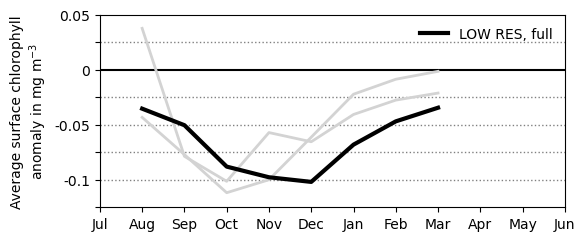

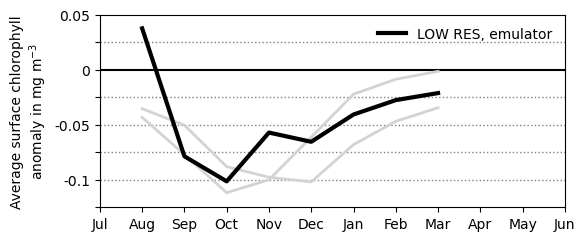

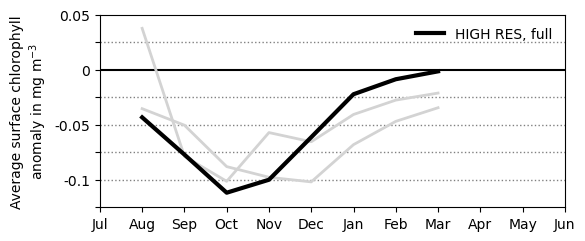

In [19]:
#---
# plot
#---
if vari=='totChl':
    def reorder_months(data):
        data2 = np.copy(data)
        data2[0:6] = data[6:]
        data2[6:] = data[0:6]
        return data2

    print('MEAN all storms LOW RES full:',np.mean(avg_anom_all))
    print('MEAN all storms LOW RES emulator:',np.mean(avg_anom_all_em))
    print('MEAN all storms HIGH RES full:',np.mean(avg_anom_all_hr))
    # CHECK: make sure these numbers match the numbers printed into histograms of Fig. 4!!!!!
    print()
    print('MEAN all storms LOW RES full:',np.nanmin(avg_anom_strongest_neg))
    print('MEAN all storms LOW RES emulator:',np.nanmin(avg_anom_strongest_neg_em))
    print('MEAN all storms HIGH RES full:',np.nanmin(avg_anom_strongest_neg_hr))
    

    months_rev = ['Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar','Apr','May','Jun']
    lw = 3
    lw2 = 1
    ww,hh = 6,2.5

    # ALL STORMS
    #fig=plt.figure(figsize=(ww,hh))
    #plt.hlines(0,0,11,color='grey',linewidth=lw-1)
    #plt.plot(reorder_months(avg_anom_all),'k',linewidth=lw,label='LOW RES, full')
    #plt.plot(reorder_months(avg_anom_all_em),'b',linewidth=lw,label='LOW RES, emulator')
    #plt.plot(reorder_months(avg_anom_all_hr),'r',linewidth=lw,label='HIGH RES, full')
    #plt.xticks(range(0,12),months_rev)
    #plt.legend(frameon=False)
    #plt.show()


    dpicnt = 150
    #----
    # NEGATIVE ANOMALIES
    #----
    
    ylim1,ylim2 = -0.125,0.05
    
    fig=plt.figure(figsize=(ww,hh))
    plt.hlines(0.025,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(0,0,11,color='k',linewidth=lw2+0.5)
    plt.hlines(-0.025,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(-0.05,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(-0.075,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(-0.1,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.plot(reorder_months(avg_anom_strongest_neg),'k',linewidth=lw,label='LOW RES, full',zorder=10)
    plt.plot(reorder_months(avg_anom_strongest_neg_em),'lightgrey',linewidth=lw-1)#,label='LOW RES, emulator')
    plt.plot(reorder_months(avg_anom_strongest_neg_hr),'lightgrey',linewidth=lw-1)#,label='HIGH RES, full')
    plt.xticks(range(0,12),months_rev)
    #plt.yticks([-0.125,-0.1,-0.075,-0.05,-0.025,0,0.025,0.05],[-0.125,-0.1,-0.075,-0.05,-0.025,0,0.025,0.05])
    plt.yticks([-0.125,-0.1,-0.075,-0.05,-0.025,0,0.025,0.05],['',-0.1,'',-0.05,'',0,'',0.05])
    plt.ylim((ylim1,ylim2))
    plt.xlim((0,11))
    plt.ylabel('Average surface chlorophyll\nanomaly in mg m$^{-3}$')
    plt.legend(frameon=False)
    if save_plots:
        filename = 'Seasonality_LOW_RES_full_'+str(perc1)+'perc_storms_strongest_neg_totChl_anomaly.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

        
    fig=plt.figure(figsize=(ww,hh))
    plt.hlines(0.025,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(0,0,11,color='k',linewidth=lw2+0.5)
    plt.hlines(-0.025,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(-0.05,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(-0.075,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(-0.1,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.plot(reorder_months(avg_anom_strongest_neg),'lightgrey',linewidth=lw-1)#,label='LOW RES, full')
    plt.plot(reorder_months(avg_anom_strongest_neg_em),'k',linewidth=lw,label='LOW RES, emulator',zorder=10)
    plt.plot(reorder_months(avg_anom_strongest_neg_hr),'lightgrey',linewidth=lw-1)#,label='HIGH RES, full')
    plt.xticks(range(0,12),months_rev)
    #plt.yticks([-0.125,-0.1,-0.075,-0.05,-0.025,0,0.025,0.05],[-0.125,-0.1,-0.075,-0.05,-0.025,0,0.025,0.05])
    plt.yticks([-0.125,-0.1,-0.075,-0.05,-0.025,0,0.025,0.05],['',-0.1,'',-0.05,'',0,'',0.05])
    plt.ylim((ylim1,ylim2))
    plt.xlim((0,11))
    plt.ylabel('Average surface chlorophyll\nanomaly in mg m$^{-3}$')
    plt.legend(frameon=False)
    if save_plots:
        filename = 'Seasonality_LOW_RES_emulator_'+str(perc1)+'perc_storms_strongest_neg_totChl_anomaly'+em_string+'.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

    fig=plt.figure(figsize=(ww,hh))
    plt.hlines(0.025,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(0,0,11,color='k',linewidth=lw2+0.5)
    plt.hlines(-0.025,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(-0.05,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(-0.075,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(-0.1,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.plot(reorder_months(avg_anom_strongest_neg),'lightgrey',linewidth=lw-1)#,label='LOW RES, full')
    plt.plot(reorder_months(avg_anom_strongest_neg_em),'lightgrey',linewidth=lw-1)#,label='LOW RES, emulator')
    plt.plot(reorder_months(avg_anom_strongest_neg_hr),'k',linewidth=lw,label='HIGH RES, full',zorder=10)
    plt.xticks(range(0,12),months_rev)
    #plt.yticks([-0.125,-0.1,-0.075,-0.05,-0.025,0,0.025,0.05],[-0.125,-0.1,-0.075,-0.05,-0.025,0,0.025,0.05])
    plt.yticks([-0.125,-0.1,-0.075,-0.05,-0.025,0,0.025,0.05],['',-0.1,'',-0.05,'',0,'',0.05])
    plt.ylim((ylim1,ylim2))
    plt.xlim((0,11))
    plt.ylabel('Average surface chlorophyll\nanomaly in mg m$^{-3}$')
    plt.legend(frameon=False)
    if save_plots:
        filename = 'Seasonality_HIGH_RES_full_'+str(perc1)+'perc_storms_strongest_neg_totChl_anomaly.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

    


Max of LOW RES full: 0.1220952644944191
Max of LOW RES emulator: 0.08732441067695618
Max of HIGH RES full: 0.1283424347639084


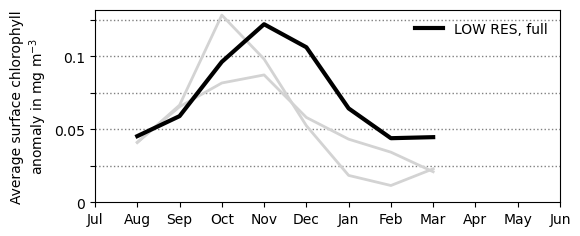

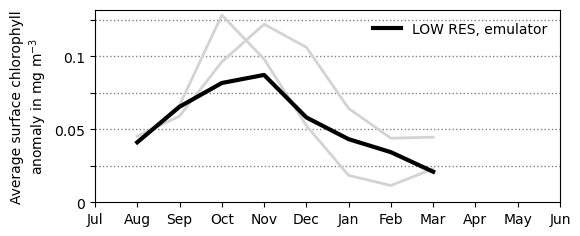

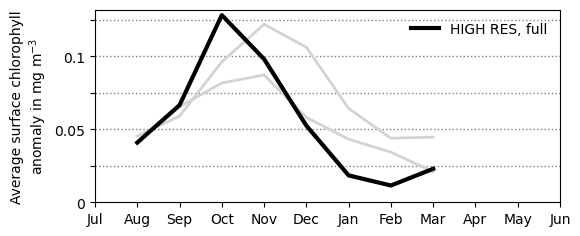

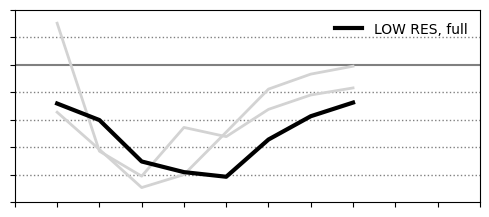

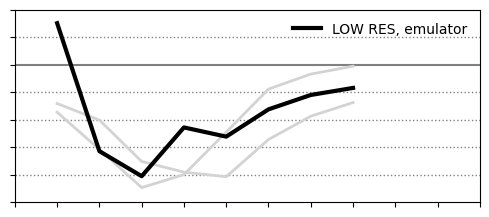

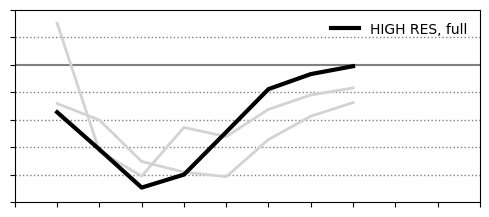

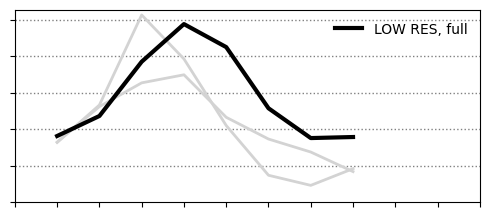

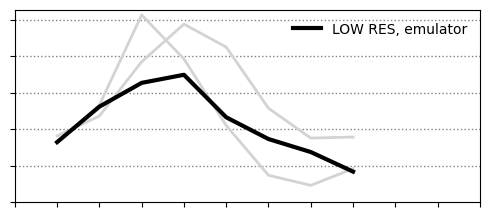

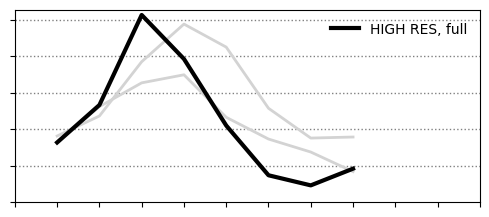

In [20]:

if vari=='totChl':
    
    #----
    # POSITIVE ANOMALIES
    #----
    ylim1,ylim2 = 0,0.132
    
    print('Max of LOW RES full:',np.nanmax(avg_anom_strongest_pos))
    print('Max of LOW RES emulator:',np.nanmax(avg_anom_strongest_pos_em))
    print('Max of HIGH RES full:',np.nanmax(avg_anom_strongest_pos_hr))
    
    fig=plt.figure(figsize=(ww,hh))
    plt.hlines(0.025,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(0.05,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(0.075,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(0.10,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(0.125,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.plot(reorder_months(avg_anom_strongest_pos),'k',linewidth=lw,label='LOW RES, full',zorder=10)
    plt.plot(reorder_months(avg_anom_strongest_pos_em),'lightgrey',linewidth=lw-1)#,label='LOW RES, emulator')
    plt.plot(reorder_months(avg_anom_strongest_pos_hr),'lightgrey',linewidth=lw-1)#,label='HIGH RES, full')
    plt.xticks(range(0,12),months_rev)
    #plt.yticks([0,0.025,0.05,0.075,0.1,0.125],[0,0.025,0.05,0.075,0.1,0.125])
    plt.yticks([0,0.025,0.05,0.075,0.1,0.125],[0,'',0.05,'',0.1,''])
    plt.ylim((ylim1,ylim2))
    plt.xlim((0,11))
    plt.ylabel('Average surface chlorophyll\nanomaly in mg m$^{-3}$')
    plt.legend(frameon=False)
    if save_plots:
        filename = 'Seasonality_LOW_RES_full_'+str(perc1)+'perc_storms_strongest_pos_totChl_anomaly.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

    fig=plt.figure(figsize=(ww,hh))
    plt.hlines(0.025,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(0.05,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(0.075,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(0.10,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(0.125,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.plot(reorder_months(avg_anom_strongest_pos),'lightgrey',linewidth=lw-1)#,label='LOW RES, full')
    plt.plot(reorder_months(avg_anom_strongest_pos_em),'k',linewidth=lw,label='LOW RES, emulator',zorder=10)
    plt.plot(reorder_months(avg_anom_strongest_pos_hr),'lightgrey',linewidth=lw-1)#,label='HIGH RES, full')
    plt.xticks(range(0,12),months_rev)
    #plt.yticks([0,0.025,0.05,0.075,0.1,0.125],[0,0.025,0.05,0.075,0.1,0.125])
    plt.yticks([0,0.025,0.05,0.075,0.1,0.125],[0,'',0.05,'',0.1,''])
    plt.ylim((ylim1,ylim2))
    plt.xlim((0,11))
    plt.ylabel('Average surface chlorophyll\nanomaly in mg m$^{-3}$')
    plt.legend(frameon=False)
    if save_plots:
        filename = 'Seasonality_LOW_RES_emulator_'+str(perc1)+'perc_storms_strongest_pos_totChl_anomaly'+em_string+'.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

    fig=plt.figure(figsize=(ww,hh))
    plt.hlines(0.025,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(0.05,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(0.075,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(0.10,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.hlines(0.125,0,11,color='grey',linewidth=lw2,linestyle=':')
    plt.plot(reorder_months(avg_anom_strongest_pos),'lightgrey',linewidth=lw-1)#,label='LOW RES, full')
    plt.plot(reorder_months(avg_anom_strongest_pos_em),'lightgrey',linewidth=lw-1)#,label='LOW RES, emulator')
    plt.plot(reorder_months(avg_anom_strongest_pos_hr),'k',linewidth=lw,label='HIGH RES, full',zorder=10)
    plt.xticks(range(0,12),months_rev)
    #plt.yticks([0,0.025,0.05,0.075,0.1,0.125],[0,0.025,0.05,0.075,0.1,0.125])
    plt.yticks([0,0.025,0.05,0.075,0.1,0.125],[0,'',0.05,'',0.1,''])
    plt.ylim((ylim1,ylim2))
    plt.xlim((0,11))
    plt.ylabel('Average surface chlorophyll\nanomaly in mg m$^{-3}$')
    plt.legend(frameon=False)
    if save_plots:
        filename = 'Seasonality_HIGH_RES_full_'+str(perc1)+'perc_storms_strongest_pos_totChl_anomaly.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)
        
        
    plot_eps = True
    if plot_eps:
        
        #----
        # NEGATIVE ANOMALIES
        #----
    
        ylim1,ylim2 = -0.125,0.05
    
        fig=plt.figure(figsize=(ww,hh))
        plt.hlines(0.025,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(0,0,11,color='grey',linewidth=lw2+0.5)
        plt.hlines(-0.025,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(-0.05,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(-0.075,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(-0.1,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.plot(reorder_months(avg_anom_strongest_neg),'k',linewidth=lw,label='LOW RES, full',zorder=10)
        plt.plot(reorder_months(avg_anom_strongest_neg_em),'lightgrey',linewidth=lw-1)#,label='LOW RES, emulator')
        plt.plot(reorder_months(avg_anom_strongest_neg_hr),'lightgrey',linewidth=lw-1)#,label='HIGH RES, full')
        plt.xticks(range(0,12),[])
        plt.yticks([-0.125,-0.1,-0.075,-0.05,-0.025,0,0.025,0.05],[])
        plt.ylim((ylim1,ylim2))
        plt.xlim((0,11))
        plt.legend(frameon=False)
        if save_plots:
            filename = 'Seasonality_LOW_RES_full_'+str(perc1)+'perc_storms_strongest_neg_totChl_anomaly.eps'
            plt.savefig(savepath+'eps/'+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
        if display_plots:
            plt.show()
        else:
            plt.close(fig)

        fig=plt.figure(figsize=(ww,hh))
        plt.hlines(0.025,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(0,0,11,color='grey',linewidth=lw2+0.5)
        plt.hlines(-0.025,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(-0.05,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(-0.075,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(-0.1,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.plot(reorder_months(avg_anom_strongest_neg),'lightgrey',linewidth=lw-1)#,label='LOW RES, full')
        plt.plot(reorder_months(avg_anom_strongest_neg_em),'k',linewidth=lw,label='LOW RES, emulator',zorder=10)
        plt.plot(reorder_months(avg_anom_strongest_neg_hr),'lightgrey',linewidth=lw-1)#,label='HIGH RES, full')
        plt.xticks(range(0,12),[])
        plt.yticks([-0.125,-0.1,-0.075,-0.05,-0.025,0,0.025,0.05],[])
        plt.ylim((ylim1,ylim2))
        plt.xlim((0,11))
        plt.legend(frameon=False)
        if save_plots:
            filename = 'Seasonality_LOW_RES_emulator_'+str(perc1)+'perc_storms_strongest_neg_totChl_anomaly'+em_string+'.eps'
            plt.savefig(savepath+'eps/'+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
        if display_plots:
            plt.show()
        else:
            plt.close(fig)

        fig=plt.figure(figsize=(ww,hh))
        plt.hlines(0.025,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(0,0,11,color='grey',linewidth=lw2+0.5)
        plt.hlines(-0.025,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(-0.05,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(-0.075,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(-0.1,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.plot(reorder_months(avg_anom_strongest_neg),'lightgrey',linewidth=lw-1)#,label='LOW RES, full')
        plt.plot(reorder_months(avg_anom_strongest_neg_em),'lightgrey',linewidth=lw-1)#,label='LOW RES, emulator')
        plt.plot(reorder_months(avg_anom_strongest_neg_hr),'k',linewidth=lw,label='HIGH RES, full',zorder=10)
        plt.xticks(range(0,12),[])
        plt.yticks([-0.125,-0.1,-0.075,-0.05,-0.025,0,0.025,0.05],[])
        plt.ylim((ylim1,ylim2))
        plt.xlim((0,11))
        plt.legend(frameon=False)
        if save_plots:
            filename = 'Seasonality_HIGH_RES_full_'+str(perc1)+'perc_storms_strongest_neg_totChl_anomaly.eps'
            plt.savefig(savepath+'eps/'+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
        if display_plots:
            plt.show()
        else:
            plt.close(fig)

        #----
        # POSITIVE ANOMALIES
        #----
        ylim1,ylim2 = 0,0.132

        fig=plt.figure(figsize=(ww,hh))
        plt.hlines(0.025,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(0.05,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(0.075,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(0.10,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(0.125,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.plot(reorder_months(avg_anom_strongest_pos),'k',linewidth=lw,label='LOW RES, full',zorder=10)
        plt.plot(reorder_months(avg_anom_strongest_pos_em),'lightgrey',linewidth=lw-1)#,label='LOW RES, emulator')
        plt.plot(reorder_months(avg_anom_strongest_pos_hr),'lightgrey',linewidth=lw-1)#,label='HIGH RES, full')
        plt.xticks(range(0,12),[])
        plt.yticks([0,0.025,0.05,0.075,0.1,0.125],[])
        plt.ylim((ylim1,ylim2))
        plt.xlim((0,11))
        plt.legend(frameon=False)
        if save_plots:
            filename = 'Seasonality_LOW_RES_full_'+str(perc1)+'perc_storms_strongest_pos_totChl_anomaly.eps'
            plt.savefig(savepath+'eps/'+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
        if display_plots:
            plt.show()
        else:
            plt.close(fig)

        fig=plt.figure(figsize=(ww,hh))
        plt.hlines(0.025,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(0.05,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(0.075,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(0.10,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(0.125,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.plot(reorder_months(avg_anom_strongest_pos),'lightgrey',linewidth=lw-1)#,label='LOW RES, full')
        plt.plot(reorder_months(avg_anom_strongest_pos_em),'k',linewidth=lw,label='LOW RES, emulator',zorder=10)
        plt.plot(reorder_months(avg_anom_strongest_pos_hr),'lightgrey',linewidth=lw-1)#,label='HIGH RES, full')
        plt.xticks(range(0,12),[])
        plt.yticks([0,0.025,0.05,0.075,0.1,0.125],[])
        plt.ylim((ylim1,ylim2))
        plt.xlim((0,11))
        plt.legend(frameon=False)
        if save_plots:
            filename = 'Seasonality_LOW_RES_emulator_'+str(perc1)+'perc_storms_strongest_pos_totChl_anomaly.eps'
            plt.savefig(savepath+'eps/'+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
        if display_plots:
            plt.show()
        else:
            plt.close(fig)

        fig=plt.figure(figsize=(ww,hh))
        plt.hlines(0.025,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(0.05,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(0.075,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(0.10,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.hlines(0.125,0,11,color='grey',linewidth=lw2,linestyle=':')
        plt.plot(reorder_months(avg_anom_strongest_pos),'lightgrey',linewidth=lw-1)#,label='LOW RES, full')
        plt.plot(reorder_months(avg_anom_strongest_pos_em),'lightgrey',linewidth=lw-1)#,label='LOW RES, emulator')
        plt.plot(reorder_months(avg_anom_strongest_pos_hr),'k',linewidth=lw,label='HIGH RES, full',zorder=10)
        plt.xticks(range(0,12),[])
        plt.yticks([0,0.025,0.05,0.075,0.1,0.125],[])
        plt.ylim((ylim1,ylim2))
        plt.xlim((0,11))
        plt.legend(frameon=False)
        if save_plots:
            filename = 'Seasonality_HIGH_RES_full_'+str(perc1)+'perc_storms_strongest_pos_totChl_anomaly.eps'
            plt.savefig(savepath+'eps/'+filename,dpi = dpicnt, bbox_inches='tight',format='eps')
        if display_plots:
            plt.show()
        else:
            plt.close(fig)


em_string 
full minus emulator: [        nan -0.04356778  0.02472655  0.03472513 -0.02225552 -0.00794876
 -0.01754193 -0.01082601 -0.01282224         nan         nan         nan]
[         nan 123.25168308 -49.08145155 -39.44692872  22.77548132
   7.79846366  25.77151872  23.08282101  37.17571978          nan
          nan          nan]


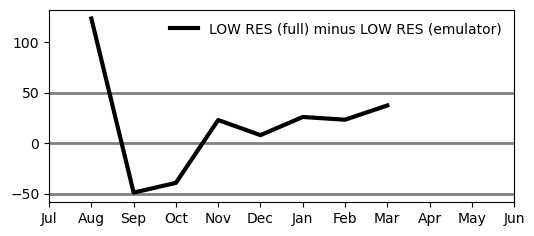

full minus emulator: [        nan  0.00214481 -0.01680272 -0.00861479  0.01343951  0.02468988
  0.01173521  0.00224445  0.01969675         nan         nan         nan]
[         nan   4.72896797 -28.44624949  -8.94724486  11.00739967
  23.22609476  18.23094633   5.10822841  44.11069583          nan
          nan          nan]


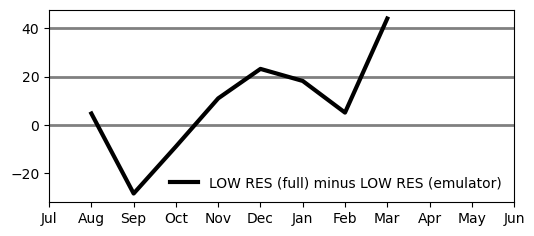

In [17]:
if vari=='totChl':
    
    print('em_string',em_string)
    
    print('full minus emulator:',reorder_months(avg_anom_strongest_neg)-reorder_months(avg_anom_strongest_neg_em))
    print(100*(reorder_months(avg_anom_strongest_neg)-reorder_months(avg_anom_strongest_neg_em))/reorder_months(avg_anom_strongest_neg))
    #----
    # NEGATIVE ANOMALIES: difference full field vs. emulator
    #----
    fig=plt.figure(figsize=(ww,hh))
    plt.hlines(0,0,11,color='grey',linewidth=lw-1)
    plt.hlines(50,0,11,color='grey',linewidth=lw-1)
    plt.hlines(-50,0,11,color='grey',linewidth=lw-1)
    plt.plot(100*(reorder_months(avg_anom_strongest_neg)-reorder_months(avg_anom_strongest_neg_em))/reorder_months(avg_anom_strongest_neg),\
             'k',linewidth=lw,label='LOW RES (full) minus LOW RES (emulator)')
    plt.xticks(range(0,12),months_rev)
    #plt.ylim((0,0.15))
    plt.xlim((0,11))
    plt.legend(frameon=False)
    if save_plots:
        filename = 'Seasonality_LOW_RES_emulator_rel_to_full_field_'+str(perc1)+'perc_storms_strongest_neg_totChl_anomaly'+em_string+'.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

    #----
    # POSITIVE ANOMALIES: difference full field vs. emulator
    #----
    print('full minus emulator:',reorder_months(avg_anom_strongest_pos)-reorder_months(avg_anom_strongest_pos_em))
    print(100*(reorder_months(avg_anom_strongest_pos)-reorder_months(avg_anom_strongest_pos_em))/reorder_months(avg_anom_strongest_pos))
    fig=plt.figure(figsize=(ww,hh))
    plt.hlines(0,0,11,color='grey',linewidth=lw-1)
    plt.hlines(20,0,11,color='grey',linewidth=lw-1)
    plt.hlines(40,0,11,color='grey',linewidth=lw-1)
    plt.plot(100*(reorder_months(avg_anom_strongest_pos)-reorder_months(avg_anom_strongest_pos_em))/reorder_months(avg_anom_strongest_pos),\
             'k',linewidth=lw,label='LOW RES (full) minus LOW RES (emulator)')
    plt.xticks(range(0,12),months_rev)
    #plt.ylim((0,0.15))
    plt.xlim((0,11))
    plt.legend(frameon=False)
    if save_plots:
        filename = 'Seasonality_LOW_RES_emulator_rel_to_full_field_'+str(perc1)+'perc_storms_strongest_pos_totChl_anomaly'+em_string+'.png'
        plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
    if display_plots:
        plt.show()
    else:
        plt.close(fig)

